# Libs Import


In [1]:
# %load_ext autoreload
# %autoreload 2
from typing import Optional, Tuple, Literal
import os
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
from scipy.stats import spearmanr, pearsonr

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platforms', 'cpu')

# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.icnn_modules import ProbStackedICNNImputer, ImputerMetrics, ProbICNNImputerTrainer, ICNNObsDecoder, StandardICNNImputerTrainer
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config, append_params_to_zip, zip_members
 

In [2]:
# ?pub_ready_plots.get_mpl_rcParams
# !pip install pub-ready-plots

In [3]:
import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True

# rc_params['font.size'] = 10
# rc_params['axes.titlesize'] = 12
# rc_params['axes.labelsize'] = 10
# rc_params['legend.fontsize'] = 10

plt.rcParams.update(rc_params)


# Experiment Defnitions

In [4]:
RESULTS_DIR = 'icnn_results_A'
EXP_DIR = {
    'ICNN_LN': 'experiment_snapshots_mimic_ProbStackedICNN_lognormal',
    'ICNN_NLN': 'experiment_snapshots_mimic_ProbStackedICNN_lognormal_normalised',
    'ICNN_KL': 'experiment_snapshots_mimic_ProbStackedICNN_kl',
    'ICNN_NKL': 'experiment_snapshots_mimic_ProbStackedICNN_kl_normalised',    
    'ICNN_MSE': 'experiment_snapshots_mimic_ProbStackedICNN_mse',
    'ICNN_NMSE': 'experiment_snapshots_mimic_ProbStackedICNN_mse_normalised',
}
PROP_MODELS = ('ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL')
DET_MODELS = ('ICNN_MSE', 'ICNN_NMSE')


ICNN_RENAMES = {
    'ICNN_LN': 'P-ICNN (LN)',
    'ICNN_NLN': 'P-ICNN (NLN)',
    'ICNN_KL': 'P-ICNN (KL)',
    'ICNN_NKL': 'P-ICNN (NKL)',    
    'ICNN_MSE': 'S-ICNN (MSE)',
    'ICNN_NMSE': 'S-ICNN (NMSE)',
}

EXP = 'ICNN_NLN'

# Data Loading

## First Time Loading and Writing to Disk

In [5]:
# tvx = m4aki.TVxAKIMIMICIVDataset.load('/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki.h5')

In [6]:
# obs = [adm.observables  for subject in tvx0.subjects.values() for adm in subject.admissions]
# adm_id = sum(([adm.admission_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])
# subj_id = sum(([subject.subject_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])

In [7]:
# obs_val = np.vstack([obs_i.value for obs_i in obs])
# obs_mask = np.vstack([obs_i.mask for obs_i in obs])
# obs_time = np.hstack([obs_i.time for obs_i in obs])

In [8]:
# tvx0.scheme.obs
# features = list(map(tvx0.scheme.obs.desc.get, tvx0.scheme.obs.codes))

In [9]:
# obs_val = pd.DataFrame(obs_val, columns=features)
# obs_mask = pd.DataFrame(obs_mask.astype(int), columns=features)
# meta = pd.DataFrame({'subject_id': subj_id, 'admission_id': adm_id, 'time': obs_time})


In [10]:
# artificial_mask = obs_mask.copy()
# artificial_mask = obs_mask & np.array(jrandom.bernoulli(jrandom.PRNGKey(0), p=0.8, shape=obs_mask.shape))


In [11]:
# obs_val.to_csv('missingness_data/missingness_vals.csv')
# obs_mask.to_csv('missingness_data/missingness_mask.csv')
# meta.to_csv('missingness_data/meta.csv')
# artificial_mask.to_csv('missingness_data/missingness_artificial_mask.csv')


## Later Loading from Disk

In [12]:
obs_val = pd.read_csv('missingness_data/missingness_vals.csv', index_col=[0])
obs_mask = pd.read_csv('missingness_data/missingness_mask.csv', index_col=[0])
artificial_mask = pd.read_csv('missingness_data/missingness_artificial_mask.csv', index_col=[0])
meta = pd.read_csv('missingness_data/meta.csv', index_col=[0])


## Split

In [13]:
split_ratio = 0.7
seed = 0
indices = jrandom.permutation(jrandom.PRNGKey(seed), len(obs_val))
train_idx = indices[:int(split_ratio * len(indices))]
test_idx = indices[int(split_ratio * len(indices)):]

obs_val_train = jnp.array(obs_val.iloc[train_idx].to_numpy())
obs_mask_train = jnp.array(obs_mask.iloc[train_idx].to_numpy())
art_mask_train =  jnp.array(artificial_mask.iloc[train_idx].to_numpy())

obs_val_test = jnp.array(obs_val.iloc[test_idx].to_numpy())
obs_mask_test = jnp.array(obs_mask.iloc[test_idx].to_numpy())
art_mask_test =  jnp.array(artificial_mask.iloc[test_idx].to_numpy())

In [14]:
cooc = obs_mask.T.dot(obs_mask)
cooc

,blood_chemistry.albumin,blood_chemistry.aniongap,blood_chemistry.bicarbonate,blood_chemistry.bun,blood_chemistry.calcium,blood_chemistry.chloride,blood_chemistry.creatinine,blood_chemistry.globulin,blood_chemistry.glucose,blood_chemistry.potassium,...,vital.glucose,vital.heart_rate,vital.mbp,vital.mbp_ni,vital.resp_rate,vital.sbp,vital.sbp_ni,vital.spo2,vital.temperature,weight.weight
blood_chemistry.albumin,10103,9441,9546,9433,8889,9605,9457,247,9512,9603,...,2933,204,149,78,202,148,76,196,62,7
blood_chemistry.aniongap,9441,70120,68995,67654,60134,69058,67533,229,67561,68868,...,22418,1686,1300,586,1673,1297,584,1598,492,84
blood_chemistry.bicarbonate,9546,68995,70515,67650,60356,69395,67422,228,67691,68985,...,22596,1715,1328,600,1698,1325,598,1622,498,86
blood_chemistry.bun,9433,67654,67650,70157,59422,68473,67857,220,66562,68480,...,22032,1682,1316,593,1663,1315,589,1586,493,79
blood_chemistry.calcium,8889,60134,60356,59422,62035,60878,59134,196,60017,60796,...,21006,1498,1132,571,1484,1133,570,1420,439,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vital.sbp,148,1297,1325,1315,1133,1423,1348,5,1234,1428,...,31619,236347,352196,224378,232839,359791,229336,225471,62274,6205
vital.sbp_ni,76,584,598,589,570,644,607,2,589,642,...,11784,113761,223891,224002,112718,229336,229374,108523,26866,1492
vital.spo2,196,1598,1622,1586,1420,1710,1631,5,1543,1738,...,40519,332944,226587,109328,327510,225471,108523,357658,86935,7215
vital.temperature,62,492,498,493,439,523,503,2,482,536,...,16654,91406,62467,26922,90028,62274,26866,86935,97964,3660


<Axes: >

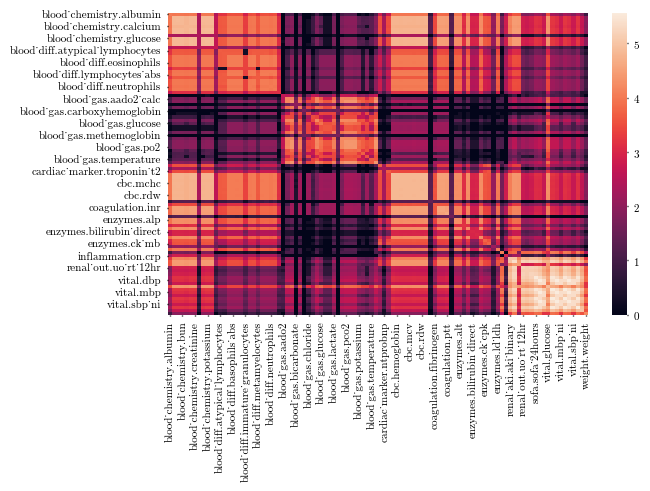

In [15]:

sns.heatmap(np.log10(cooc + 1))


In [16]:
np.mean(obs_mask)

0.08695259245595174

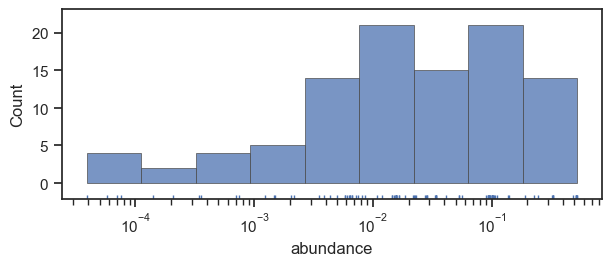

In [17]:
import matplotlib as mpl


p_mask = pd.DataFrame({'abundance': obs_mask.mean(axis=0)})


# sns.kdeplot(data=p_mask, x="abundance", log_scale=True)
# sns.rugplot(data=p_mask, x="abundance")
sns.set_theme(style="ticks")
# sns.kdeplot(data=p_mask, x="abundance", log_scale=True)
g = sns.rugplot(data=p_mask, x="abundance")
g.set_xscale('log')

sns.histplot(
    p_mask,
    x="abundance", 
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
g.get_figure().set_size_inches(fig_width_in, fig_height_in * 1.5)
g.get_figure().savefig(f"{RESULTS_DIR}/features_abundance.pdf")


# Model Configuration

In [18]:

def models(e):
    pmodels = {k: ProbStackedICNNImputer(observables_size=obs_mask.shape[1], state_size = 0, optax_optimiser_name='polyak_sgd',  
                                         positivity='abs', hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
               for k in PROP_MODELS}
    dmodels =  {k: ICNNObsDecoder(observables_size=obs_mask.shape[1], state_size = 0, optax_optimiser_name='polyak_sgd',
                                  positivity='abs', hidden_size_multiplier=3, depth=5, key=jrandom.PRNGKey(0)) 
                for k in DET_MODELS}
    return (pmodels | dmodels)[e]
    
def trainers(e):
    return {
        'ICNN_LN': ProbICNNImputerTrainer(loss='log_normal'),
        'ICNN_NLN': ProbICNNImputerTrainer(loss='log_normal', loss_feature_normalisation=True),
        'ICNN_KL': ProbICNNImputerTrainer(loss='kl_divergence'),
        'ICNN_NKL': ProbICNNImputerTrainer(loss='kl_divergence', loss_feature_normalisation=True),
        'ICNN_MSE': StandardICNNImputerTrainer(),
        'ICNN_NMSE': StandardICNNImputerTrainer(loss_feature_normalisation=True)
    }[e]

# model = models(EXP)
# trainer = trainers(EXP)

# Training

## ICNN Training

In [19]:
# lr=1e-3
# steps=10000
# train_batch_size=256
# test_batch_size=1024
# # train_batch_size=1
# # test_batch_size=1
# eval_frequency = 10
# model_snapshot_frequency = 100

# optim = optax.novograd(lr)
# opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
# data_train = (obs_val_train, obs_mask_train, art_mask_train)
# data_test = (obs_val_test, obs_mask_test, art_mask_test)

In [20]:
# train_batches = trainer.dataloader(data_train, train_batch_size, key=jrandom.PRNGKey(0))
# test_batches = iter(trainer.dataloader(data_test, train_batch_size, key=jrandom.PRNGKey(0)))
# train_history = defaultdict(list)
# test_history = defaultdict(list)
# model_snapshots = {}

In [21]:
# progress = tqdm(range(steps))

# for step, batch_train in zip(progress, train_batches):
#     start = time.time()
#     (train_loss, train_aux), model, opt_state = trainer.make_step(model, optim, opt_state, *batch_train)
#     r2_vec =  trainer.model_r_squared(model, *batch_train)
#     r2_vec_rank = trainer.model_r_squared_ranked_prob(model, *batch_train, k=5)
#     r2_vec = np.array(r2_vec)
#     train_nsteps = int(sum(train_aux.n_steps) / len(train_aux.n_steps))
#     train_history['R2'].append(r2_vec)
#     train_history['R2_rank5'].append(r2_vec_rank)
#     train_history['loss'].append(train_loss)
#     train_history['n_opt_steps'].append(train_nsteps)
    
#     end = time.time()
#     if (step % eval_frequency) == 0 or step == steps - 1:
#         batch_test = next(test_batches)
#         test_loss, _ = trainer.loss(model, *batch_test)
#         r2_vec_test = trainer.model_r_squared(model, *batch_test)
#         r2_vec_rank_test = trainer.model_r_squared_ranked_prob(model, *batch_test, k=10)
#         r2_vec_test = np.array(r2_vec_test)
#         test_history['loss'].append(test_loss)
#         test_history['R2'].append(r2_vec_test)
#         test_history['R2_rank10'].append(r2_vec_rank_test)

#     if (step % model_snapshot_frequency) == 0 or step == steps - 1:
#         model_snapshots[step] = model
#         append_params_to_zip(model, f'step{step:04d}.eqx', f'{EXP_DIR[EXP]}/params.zip')

#     progress.set_description(f"Trn-L: {train_loss:.3f}, Trn-R2: ({np.nanmax(r2_vec_rank):.2f}, {np.nanmin(r2_vec_rank):.2f}, {np.nanmean(r2_vec_rank):.2f}, {np.nanmedian(r2_vec_rank):.2f}),  Trn-N-steps: {train_nsteps}, " 
#                              f"Tst-L:  {test_loss:.3f}, Tst-R2:  ({np.nanmax(r2_vec_rank_test):.2f}, {np.nanmin(r2_vec_rank_test):.2f}, {np.nanmean(r2_vec_rank_test):.2f}, {np.nanmedian(r2_vec_rank_test):.2f}), "
#                              f"Computation time: {end - start:.2f}, ")
                            

In [22]:
# zip_members(f'{EXP_DIR}/params.zip')

### Dump Training Statistics

In [ ]:
# FIRST TIME - BEGIN 

# train_stats = pd.DataFrame(train_history)
# test_stats = pd.DataFrame(test_history)

# train_stats['split'] = 'Train'
# train_stats['iteration'] = train_stats.index + 1
# test_stats['split'] = 'Test'
# test_stats['iteration'] = (test_stats.index * eval_frequency) + 1
# training_stats = pd.concat([train_stats, test_stats])
# training_stats_melted = pd.melt(training_stats, value_vars=['loss'], id_vars=['split', 'iteration'], value_name='Loss')
# training_stats_melted = training_stats_melted.astype({'Loss': float})

# training_stats.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv')  
# training_stats_melted.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv')  

# FIRST TIME - END 


# LATER TIMES
training_stats = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv', index_col=[0])  
training_stats_melted = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv', index_col=[0])  



g2 = sns.lineplot(data=training_stats_melted, x="iteration", y="Loss", hue="split")
g2.get_figure().set_size_inches(fig_width_in, fig_height_in)
g2.get_figure().savefig(f"{RESULTS_DIR}/{EXP}_training_stats.pdf")

## Sklearn Training

In [23]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

sklearn_imputers =  {
    'zero_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    'mean_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn_imputer': lambda: KNNImputer(missing_values=np.nan),
    'iter_imputer': lambda: IterativeImputer(
        missing_values=np.nan,
        add_indicator=False,
        random_state=0,
        n_nearest_features=5,
        max_iter=5,
        sample_posterior=True,
    )
}

# sklearn_trained_imputers = {k: v().fit(np.where(obs_mask_train, obs_val_train, np.nan)) for k, v in sklearn_imputers.items()} 

# Metrics / Results

In [24]:
prediction_mask = (1 - art_mask_test) * obs_mask_test
feature2index =  dict(zip(obs_val.columns, range(len(obs_val.columns))))
n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)
n_test = ((1 - art_mask_test) * obs_mask_test).sum(axis=0)
n_train_measured = obs_mask_train.sum(axis=0)
missingness = 1 - obs_mask.mean(axis=0)
validation_missingness = 1 - pd.DataFrame(art_mask_test, columns=obs_mask.columns).mean(axis=0)

In [25]:
n_test_censored = pd.Series(prediction_mask.sum(axis=0), index=obs_val.columns)
p_test_censored = n_test_censored / len(prediction_mask)
vars_n300 = n_test_censored[n_test_censored >= 300].index
vars_n300_r = n_test_censored[n_test_censored < 300].index
vars_n300, len(vars_n300)

(Index(['blood_chemistry.albumin', 'blood_chemistry.aniongap',
        'blood_chemistry.bicarbonate', 'blood_chemistry.bun',
        'blood_chemistry.calcium', 'blood_chemistry.chloride',
        'blood_chemistry.creatinine', 'blood_chemistry.glucose',
        'blood_chemistry.potassium', 'blood_chemistry.sodium',
        'blood_diff.basophils', 'blood_diff.basophils_abs',
        'blood_diff.eosinophils', 'blood_diff.eosinophils_abs',
        'blood_diff.lymphocytes', 'blood_diff.lymphocytes_abs',
        'blood_diff.monocytes', 'blood_diff.monocytes_abs',
        'blood_diff.neutrophils', 'blood_diff.neutrophils_abs',
        'blood_gas.aado2_calc', 'blood_gas.baseexcess', 'blood_gas.calcium',
        'blood_gas.fio2_chartevents', 'blood_gas.glucose', 'blood_gas.lactate',
        'blood_gas.pao2fio2ratio', 'blood_gas.pco2', 'blood_gas.ph',
        'blood_gas.po2', 'blood_gas.potassium', 'blood_gas.totalco2',
        'cardiac_marker.ck_mb', 'cardiac_marker.troponin_t2', 'cbc.hematocri

In [26]:
variable_map = {'blood_chemistry.albumin': 'Albumin',  'blood_chemistry.aniongap': 'Aniongap',  'blood_chemistry.bicarbonate': 'Bicarbonate',  'blood_chemistry.bun': 'Urea Nitrogen',  'blood_chemistry.calcium': 'Calcium',  'blood_chemistry.chloride': 'Chloride',  'blood_chemistry.creatinine': 'Creatinine',  'blood_chemistry.globulin': 'Globulin',  'blood_chemistry.glucose': 'Glucose',  'blood_chemistry.potassium': 'Potassium',  'blood_chemistry.sodium': 'Sodium',  'blood_chemistry.total_protein': 'Protein Total',  'blood_diff.atypical_lymphocytes': 'Atypical Lymphocytes',  'blood_diff.bands': 'Bands (%)',  'blood_diff.basophils': 'Basophils',  'blood_diff.basophils_abs': 'Abs Basophils',  'blood_diff.eosinophils': 'Eosinophils',  'blood_diff.eosinophils_abs': 'Abs Eosinophils',  'blood_diff.immature_granulocytes': 'Immature Granulocytes',  'blood_diff.lymphocytes': 'Lymphocytes',  'blood_diff.lymphocytes_abs': 'Abs Lymphocytes',  'blood_diff.metamyelocytes': 'Metamyelocytes',  'blood_diff.monocytes': 'Monocytes',  'blood_diff.monocytes_abs': 'Abs Monocytes',  'blood_diff.neutrophils': 'Neutrophils',  'blood_diff.neutrophils_abs': 'Abs Neutrophil',  'blood_diff.nrbc': 'NRBC',  'blood_gas.aado2': 'AaDO2',  'blood_gas.aado2_calc': 'AaDO2_calc',  'blood_gas.baseexcess': 'Base excess',  'blood_gas.bicarbonate': 'Bicarbonate',  'blood_gas.calcium': 'Calcium',  'blood_gas.carboxyhemoglobin': 'Carboxyhemoglobin',  'blood_gas.chloride': 'Chloride',  'blood_gas.fio2': 'FiO2',  'blood_gas.fio2_chartevents': 'FiO2_chartevents',  'blood_gas.glucose': 'Glucose',  'blood_gas.hematocrit': 'Hematocrit',  'blood_gas.hemoglobin': 'Hemoglobin',  'blood_gas.lactate': 'Lactate',  'blood_gas.methemoglobin': 'Methemoglobin',  'blood_gas.pao2fio2ratio': 'pO2/FiO2 ratio',  'blood_gas.pco2': 'pCO2',  'blood_gas.ph': 'pH',  'blood_gas.po2': 'pO2',  'blood_gas.potassium': 'Potassium',  'blood_gas.so2': 'sO2',  'blood_gas.sodium': 'Sodium',  'blood_gas.temperature': 'Temperature',  'blood_gas.totalco2': 'CO2 total',  'cardiac_marker.ck_mb': 'Creatinine Kinase, MB',  'cardiac_marker.ntprobnp': 'NT-proBNP',  'cardiac_marker.troponin_t2': 'Troponin T',  'cbc.hematocrit': 'Hematocrit',  'cbc.hemoglobin': 'Hemoglobin',  'cbc.mch': 'MCH',  'cbc.mchc': 'MCHC',  'cbc.mcv': 'MCV',  'cbc.platelet': 'Platelet',  'cbc.rbc': 'RBC',  'cbc.rdw': 'RDW',  'cbc.wbc': 'WBC',  'coagulation.d_dimer': 'D-Dimer',  'coagulation.fibrinogen': 'Fibrinogen',  'coagulation.inr': 'INR',  'coagulation.pt': 'PT',  'coagulation.ptt': 'PTT',  'coagulation.thrombin': 'Thrombin',  'enzymes.alp': 'ALP',  'enzymes.alt': 'ALT',  'enzymes.amylase': 'Amylase',  'enzymes.ast': 'AST',  'enzymes.bilirubin_direct': 'Bilirubin direct',  'enzymes.bilirubin_indirect': 'Bilirubin indirect',  'enzymes.bilirubin_total': 'Bilirubin total',  'enzymes.ck_cpk': 'CK-CPK',  'enzymes.ck_mb':'CK-MB',  'enzymes.ggt': 'GGT',  'enzymes.ld_ldh': 'ld_ldh',  'icp.icp': 'Intra-cranial Press.',  'inflammation.crp': 'CRP',  'renal_aki.aki_binary': 'AKI (binary)',  'renal_aki.aki_stage_smoothed': 'AKI',  'renal_creat.creat': 'Creatinine',  'renal_out.uo_rt_12hr': 'Urine out 12h',  'renal_out.uo_rt_24hr': 'Urine out 24h',  'renal_out.uo_rt_6hr': 'Urine out 6h',  'sofa.sofa_24hours': 'SOFA',  'vital.dbp': 'Diastolic BP',  'vital.dbp_ni': 'NI-Diastolic BP',  'vital.glucose': 'Glucose',  'vital.heart_rate': 'Heart Rate',  'vital.mbp':  'Mean BP',  'vital.mbp_ni': 'NI Mean BP',  'vital.resp_rate': 'Respiratory Rate',  'vital.sbp': 'Systolic BP',  'vital.sbp_ni':  'NI-Systolic BP',  'vital.spo2': 'SpO2',  'vital.temperature': 'Temperature',  'weight.weight': 'Weight'}

## Metrics Evolution with ICNN Training

In [27]:
# FIRST TIME - BEGIN 

# dataframes = []
# for step, model_snap in tqdm(model_snapshots.items()):
#     with jax.default_device(jax.devices("cpu")[0]):
#         obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#         (X_test_imp, X_test_std), _ = eqx.filter_vmap(model_snap.prob_partial_input_optimise)(obs_test, art_mask_test)
    
#     sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
#     r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                           for t in sigma_threshold]
    
#     r2_test_results = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
#     r2_test_results['sigma_threshold'] = sigma_threshold
#     r2_test_results['step'] = step
#     dataframes.append(r2_test_results)

# r2_iters_test_results = pd.concat(dataframes)
# r2_iters_test_results = pd.melt(r2_iters_test_results, value_vars=list(obs_val.columns), id_vars=['sigma_threshold', 'step'], value_name='R2')

# r2_iters_test_results.to_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv')
# FIRST TIME - END 
# r2_iters_test_results = pd.read_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv', index_col=[0])

In [28]:
# r2_iters_test_results

## Metrics of the Last ICNN Snapshot

### Inference with Last ICNN Snapshot (one-time)

In [29]:
# FIRST TIME - BEGIN 
# model = model.load_params_from_archive(f'{EXP_DIR[EXP]}/params.zip', 'step9999.eqx')
# with jax.default_device(jax.devices("cpu")[0]):
#     obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#     (X_test_imp, X_test_std), _ = eqx.filter_vmap(model.prob_partial_input_optimise)(obs_test, art_mask_test)

# X_test_imp_df = pd.DataFrame(X_test_imp, columns=obs_val.columns)
# X_test_std_df = pd.DataFrame(X_test_std, columns=obs_val.columns)

# X_test_imp_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_imp.csv')
# X_test_std_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_std.csv')
# FIRST TIME - END 

### Load ICNN Inference from Disk (one-time)

In [30]:
vars_n300

Index(['blood_chemistry.albumin', 'blood_chemistry.aniongap',
       'blood_chemistry.bicarbonate', 'blood_chemistry.bun',
       'blood_chemistry.calcium', 'blood_chemistry.chloride',
       'blood_chemistry.creatinine', 'blood_chemistry.glucose',
       'blood_chemistry.potassium', 'blood_chemistry.sodium',
       'blood_diff.basophils', 'blood_diff.basophils_abs',
       'blood_diff.eosinophils', 'blood_diff.eosinophils_abs',
       'blood_diff.lymphocytes', 'blood_diff.lymphocytes_abs',
       'blood_diff.monocytes', 'blood_diff.monocytes_abs',
       'blood_diff.neutrophils', 'blood_diff.neutrophils_abs',
       'blood_gas.aado2_calc', 'blood_gas.baseexcess', 'blood_gas.calcium',
       'blood_gas.fio2_chartevents', 'blood_gas.glucose', 'blood_gas.lactate',
       'blood_gas.pao2fio2ratio', 'blood_gas.pco2', 'blood_gas.ph',
       'blood_gas.po2', 'blood_gas.potassium', 'blood_gas.totalco2',
       'cardiac_marker.ck_mb', 'cardiac_marker.troponin_t2', 'cbc.hematocrit',
       'cbc

In [31]:
all_models_X_test_imp_df = {}
prob_models_X_test_std_df = {}
prob_models_X_var_stats_df = []
all_models_X_test_se = []
all_models_features_stats_df = []
all_models_stats_df = []

for model_name in list(EXP_DIR.keys()) + list(sklearn_imputers.keys()):
    x_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_imp.csv'
    s_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_std.csv'
    if os.path.isfile(x_file):
        X_test_imp_ = pd.read_csv(x_file, index_col=[0])
        all_models_X_test_imp_df[model_name] = X_test_imp_

        # Squared-Errors (per instance)
        X_test_se_ = (X_test_imp_ - np.array(obs_val_test))**2
        X_test_se_ = X_test_se_.where(prediction_mask.astype(bool), other=np.nan)
        X_test_se_ = pd.melt(X_test_se_, value_vars=list(obs_val.columns), value_name='SE')
        X_test_se_ = X_test_se_[X_test_se_.SE.notnull()]
        X_test_se_['Imputer'] = model_name
        all_models_X_test_se.append(X_test_se_)


    if os.path.isfile(s_file):
        X_test_std_ = pd.read_csv(s_file, index_col=[0])
        prob_models_X_test_std_df[model_name] = X_test_std_
        
        X_test_var_ = np.where(prediction_mask.astype(bool), X_test_std_ ** 2, np.nan)
        SE_ = (all_models_X_test_imp_df[model_name] - np.array(obs_val_test)) ** 2
        SE_ = np.where(prediction_mask.astype(bool), SE_, np.nan)
        se_data_ = defaultdict(list)
        for i in range(SE_.shape[1]):
            se_data_['SE'].extend(np.array(SE_[:, i][prediction_mask[:, i].astype(bool)]).tolist())
            se_data_[r'$\hat{\sigma}^2$'].extend(np.array(X_test_var_[:, i][prediction_mask[:, i].astype(bool)]).tolist())
            se_data_['Feature'].extend([obs_val.columns[i]] * int(prediction_mask[:, i].sum()))
        se_df_ = pd.DataFrame(se_data_)
        se_df_['Imputer'] = model_name
        prob_models_X_var_stats_df.append(se_df_)

    if model_name not in all_models_X_test_imp_df:
        continue

    # R2/MSE (per feature)
    X_test_imp_ = jnp.array(all_models_X_test_imp_df[model_name])
    features_r2_ = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp_.T, prediction_mask.T)
    se_ = (np.array(all_models_X_test_imp_df[model_name]) - np.array(obs_val_test)) ** 2
    mse_ = np.nanmean(se_, axis=0, where=prediction_mask.astype(bool))
    features_stats_df_ = pd.DataFrame({r'$R^2$': np.array(features_r2_), 
                                       'MSE': mse_,
                                       'Feature': all_models_X_test_imp_df[model_name].columns,
                                       'Imputer': [model_name] * len(mse_)})

    # r_spearman(SE, sigma2) (per feature)
    if model_name in prob_models_X_test_std_df:
        X_test_var_ = np.where(prediction_mask.astype(bool), prob_models_X_test_std_df[model_name] ** 2, np.nan)
        features_stats_df_[r'$r(SE, \hat{\sigma}^2)$'] = [spearmanr(se_i[mi], sigma2_i[mi]).statistic
                                                 for se_i, sigma2_i, mi in zip(se_.T, X_test_var_.T, prediction_mask.astype(bool).T)]

    all_models_features_stats_df.append(features_stats_df_)

    # R2/MSE (per model)
    features_stats_300_df = features_stats_df_[features_stats_df_.Feature.isin(vars_n300)]
    weighted_avg_R2 = np.average(features_stats_300_df[r'$R^2$'], 
                                 weights=features_stats_300_df['Feature'].map(n_test_censored))
    
    model_stats_df_ = pd.DataFrame({'Imputer': [model_name],
                                    'MSE': [np.nanmean(se_, where=prediction_mask.astype(bool))],
                                    r'$R^2$': [ProbICNNImputerTrainer.r_squared(obs_val_test, X_test_imp_, prediction_mask).item()],
                                    r'MICRO-AVG($R^2$)': [ProbICNNImputerTrainer.r_squared_micro_average(obs_val_test, X_test_imp_, prediction_mask).item()],
                                    r'MACRO-AVG($R^2$)*': [features_stats_300_df[r'$R^2$'].mean()]})

    # corr(SE, sigma2) (per model)
    if model_name in prob_models_X_test_std_df:
        X_test_var_ = np.where(prediction_mask.astype(bool), prob_models_X_test_std_df[model_name] ** 2, np.nan).flatten()
        m_ = prediction_mask.astype(bool).flatten()
        model_stats_df_[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(se_.flatten()[m_], X_test_var_[m_]).statistic]
        model_stats_df_[r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$'] = [spearmanr(se_.flatten()[m_], X_test_var_[m_]).statistic]
    all_models_stats_df.append(model_stats_df_)
    
all_models_X_test_se = pd.concat(all_models_X_test_se)
prob_models_X_var_stats_df = pd.concat(prob_models_X_var_stats_df)
all_models_features_stats_df = pd.concat(all_models_features_stats_df)
all_models_stats_df = pd.concat(all_models_stats_df)

In [32]:
all_models_features_stats_df.Imputer.unique()

array(['ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL', 'ICNN_MSE',
       'ICNN_NMSE', 'zero_imputer', 'mean_imputer', 'knn_imputer',
       'iter_imputer'], dtype=object)

In [33]:
p_abundance = obs_mask.mean(axis=0)
for name, model_df in all_models_features_stats_df.groupby('Imputer'):
    df = model_df[model_df.Feature.isin(vars_n300)]
    stat = spearmanr(df[r'$R^2$'], df.Feature.map(p_abundance)).statistic
    loc = all_models_stats_df.Imputer == name
    all_models_stats_df.loc[loc, r'$r_\text{Spearman}(R^2, \text{abundance})$'] = stat
    

In [34]:
all_models_stats_df

,Imputer,MSE,$R^2$,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*,"$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(R^2, \text{abundance})$"
0,ICNN_LN,0.110200,0.088884,-0.097980,-14.683217,0.486482,0.528621,0.622578
0,ICNN_NLN,0.092614,0.234282,0.077238,-0.977603,0.359050,0.523306,0.443354
0,ICNN_KL,0.085771,0.290860,0.145420,-8.980603,0.011902,0.182318,0.380291
0,ICNN_NKL,0.081217,0.328510,0.190792,-8.052747,0.027086,0.196668,0.253702
0,ICNN_MSE,0.103783,0.141939,-0.034043,-0.636587,NaN,NaN,0.157781
0,ICNN_NMSE,0.094326,0.220125,0.060177,-0.046894,NaN,NaN,-0.135166
0,zero_imputer,0.188635,-0.559605,-0.879470,-4.101035,NaN,NaN,-0.420739
0,mean_imputer,0.100373,0.170128,-0.000074,-0.000799,NaN,NaN,0.413396
0,knn_imputer,0.142751,-0.180250,-0.422312,0.143208,NaN,NaN,-0.142324
0,iter_imputer,0.086248,0.286912,0.140662,-0.229407,NaN,NaN,0.077502


In [35]:
all_models_features_stats_df

,$R^2$,MSE,Feature,Imputer,"$r(SE, \hat{\sigma}^2)$"
0,-18.791556,0.338596,blood_chemistry.albumin,ICNN_LN,-0.095714
1,-0.633369,0.032923,blood_chemistry.aniongap,ICNN_LN,0.151935
2,-0.511465,0.020465,blood_chemistry.bicarbonate,ICNN_LN,0.113759
3,-0.219971,0.051564,blood_chemistry.bun,ICNN_LN,0.058487
4,-2.204620,0.012969,blood_chemistry.calcium,ICNN_LN,0.103926
...,...,...,...,...,...
95,0.452593,0.007647,vital.sbp,iter_imputer,NaN
96,0.820376,0.002518,vital.sbp_ni,iter_imputer,NaN
97,-0.972564,0.001281,vital.spo2,iter_imputer,NaN
98,-0.918125,0.000421,vital.temperature,iter_imputer,NaN


In [36]:
r_classes = [r'$r > 0.3$', r'$r \in [0.1, 0.3]$', r'$r \in [-0.1, 0.1]$', r'$r \leq -0.1$']
R_classes = [r'$R^2 > 0.25$', r'$R^2 \in (0.1, 0.25]$', r'$R^2 \in [-0.1, 0.1]$', r'$R^2 \in (-1, -0.1]$',  r'$R^2 \in (-9, -1]$', r'$R^2 < -9$']
def classify_r(r):
    if r > 0.3:
        return r_classes[0]
    elif r > 0.1:
        return r_classes[1]
    elif r >= -0.1:
        return r_classes[2]
    elif r < -0.1:
        return r_classes[3]
    else:
        return 'NA'

def classify_R(R):
    if R > 0.25:
        return R_classes[0]
    elif R > 0.1:
        return R_classes[1]
    elif R >= -0.1:
        return R_classes[2]
    elif R >= -1:
        return R_classes[3] 
    elif R >= -9:
        return R_classes[4]
    elif R < -9:
        return R_classes[5]
    else:
        return 'NA'

all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'] = all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$'].map(classify_r)
all_models_features_stats_df[r'$R^2$ bin'] = all_models_features_stats_df[r'$R^2$'].map(classify_R)


In [37]:
all_models_features_stats_df

,$R^2$,MSE,Feature,Imputer,"$r(SE, \hat{\sigma}^2)$","$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin
0,-18.791556,0.338596,blood_chemistry.albumin,ICNN_LN,-0.095714,"$r \in [-0.1, 0.1]$",$R^2 < -9$
1,-0.633369,0.032923,blood_chemistry.aniongap,ICNN_LN,0.151935,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
2,-0.511465,0.020465,blood_chemistry.bicarbonate,ICNN_LN,0.113759,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
3,-0.219971,0.051564,blood_chemistry.bun,ICNN_LN,0.058487,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$"
4,-2.204620,0.012969,blood_chemistry.calcium,ICNN_LN,0.103926,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$"
...,...,...,...,...,...,...,...
95,0.452593,0.007647,vital.sbp,iter_imputer,NaN,NA,$R^2 > 0.25$
96,0.820376,0.002518,vital.sbp_ni,iter_imputer,NaN,NA,$R^2 > 0.25$
97,-0.972564,0.001281,vital.spo2,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"
98,-0.918125,0.000421,vital.temperature,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"


In [38]:
prob_models_features_stats_df = all_models_features_stats_df[all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$'].notnull()]
prob_models_features_stats_df = prob_models_features_stats_df[prob_models_features_stats_df.Feature.isin(vars_n300)]

prob_models_features_stats_df['Imputer'] = prob_models_features_stats_df['Imputer'].map(ICNN_RENAMES)

r_bins = prob_models_features_stats_df.groupby(['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin'])['Feature'].count().reset_index()
r_bins.columns = ['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin', 'Count']
r_bins = r_bins.pivot_table(index="Imputer", values='Count', columns=r'$r(SE, \hat{\sigma}^2)$ bin')

# r_bins = r_bins[r_classes]
r_bins

"$r(SE, \hat{\sigma}^2)$ bin",$r > 0.3$,"$r \in [-0.1, 0.1]$","$r \in [0.1, 0.3]$",$r \leq -0.1$
Imputer,,,,
P-ICNN (KL),1.0,51.0,19.0,2.0
P-ICNN (LN),4.0,43.0,25.0,1.0
P-ICNN (NKL),1.0,57.0,15.0,NaN
P-ICNN (NLN),3.0,53.0,17.0,NaN


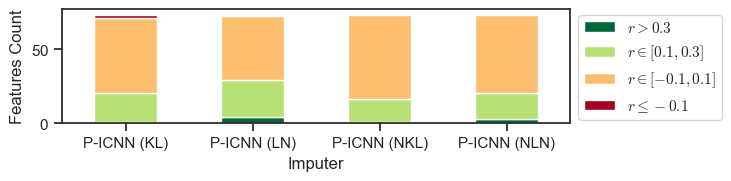

In [39]:
ax = r_bins.plot(y=r_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 1.2, fig_height_in)
ax.get_figure().savefig(f"{RESULTS_DIR}/prob_icnn_r_bins.pdf")

In [61]:
table_ablation0 = all_models_stats_df.copy()

table_ablation0['Imputer'] = all_models_stats_df['Imputer'].map(ICNN_RENAMES)
ablation_models = [m for m in table_ablation0.Imputer.unique() if m == m and  m.startswith('P-ICNN')]

table_ablation0 = table_ablation0.set_index('Imputer').loc[ablation_models,  ['MSE', r'MICRO-AVG($R^2$)',  r'MACRO-AVG($R^2$)*', r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$'] ].transpose()
table_ablation0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table_ablation0.columns))
table_ablation0.columns = list(map(lambda c: c.replace("_", "\\_"), table_ablation0.columns))
table_ablation0.columns.name = 'Imputer'
table_ablation0 = table_ablation0.sort_values('MSE', ascending=False, axis=1)
table_ablation0

Imputer,\texttt{P-ICNN (LN)},\texttt{P-ICNN (NLN)},\texttt{P-ICNN (KL)},\texttt{P-ICNN (NKL)}
MSE,0.110200,0.092614,0.085771,0.081217
MICRO-AVG($R^2$),-0.097980,0.077238,0.145420,0.190792
MACRO-AVG($R^2$)*,-14.683217,-0.977603,-8.980603,-8.052747
"$r_\text{Spearman}(SE, \hat{\sigma}^2)$",0.528621,0.523306,0.182318,0.196668


In [62]:
table_stl_ablation0 = (table_ablation0.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.08, high=0.110,  vmin=0.08, vmax=0.110, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table_stl_ablation0

Imputer,\texttt{P-ICNN (LN)},\texttt{P-ICNN (NLN)},\texttt{P-ICNN (KL)},\texttt{P-ICNN (NKL)}
MSE,0.110,0.093,0.086,0.081
MICRO-AVG($R^2$),-0.098,0.077,0.145,0.191
MACRO-AVG($R^2$)*,-14.683,-0.978,-8.981,-8.053
"$r_\text{Spearman}(SE, \hat{\sigma}^2)$",0.529,0.523,0.182,0.197


In [69]:
table_ltx_ablation0 = (table_stl_ablation0.to_latex(caption=r"Ablation study on the effect of the probabilistic loss function choice on the performance of "
                                                    r"\texttt{P-ICNN} models. "
                                                    r"First row: \gls*{mse} loss across all features on the test split. "
                                                    r"Second and third rows list the micro and macro average of $R^2$ (higher is better), respectively. "
                                                    r"For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, "
                                                    r"of which some have $-\infty$ values. "
                                                    r"Last row: correlation between squared error and predicted variance (the higher the better).",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table_ltx_ablation0)

\begin{table}
\centering
\caption{Ablation study on the effect of the probabilistic loss function choice on the performance of \texttt{P-ICNN} models. First row: \gls*{mse} loss across all features on the test split. Second and third rows list the micro and macro average of $R^2$ (higher is better), respectively. For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, of which some have $-\infty$ values. Last row: correlation between squared error and predicted variance (the higher the better).}
\begin{tabular}{lrrrr}
\hline
Imputer & \texttt{P-ICNN (LN)} & \texttt{P-ICNN (NLN)} & \texttt{P-ICNN (KL)} & \texttt{P-ICNN (NKL)} \\
\hline
MSE & {\cellcolor[HTML]{D02927}} \color[HTML]{F1F1F1} 0.110 & {\cellcolor[HTML]{E0F295}} \color[HTML]{000000} 0.093 & {\cellcolor[HTML]{78C565}} \color[HTML]{000000} 0.086 & {\cellcolor[HTML]{199750}} \color[HTML]{F1F1F1} 0.081 \\
MICRO-AVG($R^2$) & -0.098 & 0.077 & 0.145 & 0.191 \\
MACRO-AVG($R^2$)* & -14.683 & -

In [65]:
table_ablation1 = all_models_stats_df.copy()

table_ablation1['Imputer'] = all_models_stats_df['Imputer'].map(ICNN_RENAMES)
ablation_models = [m for m in table_ablation1.Imputer.unique() if m == m and  m.startswith('S-ICNN')]

table_ablation1 = table_ablation1.set_index('Imputer').loc[ablation_models,  ['MSE', r'MICRO-AVG($R^2$)', r'MACRO-AVG($R^2$)*'] ].transpose()
table_ablation1.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table_ablation1.columns))
table_ablation1.columns = list(map(lambda c: c.replace("_", "\\_"), table_ablation1.columns))
table_ablation1.columns.name = 'Imputer'
table_ablation1 = table_ablation1.sort_values('MSE', ascending=False, axis=1)
table_ablation1

Imputer,\texttt{S-ICNN (MSE)},\texttt{S-ICNN (NMSE)}
MSE,0.103783,0.094326
MICRO-AVG($R^2$),-0.034043,0.060177
MACRO-AVG($R^2$)*,-0.636587,-0.046894


In [66]:
table_stl_ablation1 = (table_ablation1.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.08, high=0.110,  vmin=0.08, vmax=0.110, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table_stl_ablation1

Imputer,\texttt{S-ICNN (MSE)},\texttt{S-ICNN (NMSE)}
MSE,0.104,0.094
MICRO-AVG($R^2$),-0.034,0.060
MACRO-AVG($R^2$)*,-0.637,-0.047


In [68]:
table_ltx_ablation1 = (table_stl_ablation1.to_latex(caption=r"Ablation study on the effect of the loss function choice on the performance of \texttt{S-ICNN} models. "
                                                    r"First row: \gls*{mse} loss across all features on the test split. Second and third rows list the micro and macro average of $R^2$ "
                                                    r"(higher is better), respectively. For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, "
                                                    r"of which some have $-\infty$ values.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table_ltx_ablation1)

\begin{table}
\centering
\caption{Ablation study on the effect of the loss function choice on the performance of \texttt{S-ICNN} models. First row: \gls*{mse} loss across all features on the test split. Second and third rows list the micro and macro average of $R^2$ (higher is better), respectively. For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, of which some have $-\infty$ values.}
\begin{tabular}{lrr}
\hline
Imputer & \texttt{S-ICNN (MSE)} & \texttt{S-ICNN (NMSE)} \\
\hline
MSE & {\cellcolor[HTML]{FA9857}} \color[HTML]{000000} 0.104 & {\cellcolor[HTML]{F2FAAE}} \color[HTML]{000000} 0.094 \\
MICRO-AVG($R^2$) & -0.034 & 0.060 \\
MACRO-AVG($R^2$)* & -0.637 & -0.047 \\
\hline
\end{tabular}
\end{table}



In [49]:
all_models_X_test_se

,variable,SE,Imputer
1065,blood_chemistry.albumin,0.698059,ICNN_LN
1230,blood_chemistry.albumin,0.687116,ICNN_LN
1484,blood_chemistry.albumin,0.000719,ICNN_LN
1675,blood_chemistry.albumin,0.000834,ICNN_LN
1847,blood_chemistry.albumin,0.201607,ICNN_LN
...,...,...,...
20815337,weight.weight,0.015889,iter_imputer
20815638,weight.weight,0.091407,iter_imputer
20815715,weight.weight,0.088486,iter_imputer
20815748,weight.weight,0.004486,iter_imputer


In [70]:
S_ICNN = 'ICNN_NMSE'
P_ICNN = 'ICNN_NKL'


final_models_X_test_se = all_models_X_test_se[(all_models_X_test_se.Imputer.str.count('ICNN') == 0) | (all_models_X_test_se.Imputer.isin((S_ICNN, P_ICNN)))]
final_models_features_stats_df = all_models_features_stats_df[(all_models_features_stats_df.Imputer.str.count('ICNN') == 0) | (all_models_features_stats_df.Imputer.isin((S_ICNN, P_ICNN)))]
final_models_stats_df = all_models_stats_df[(all_models_stats_df.Imputer.str.count('ICNN') == 0) | (all_models_stats_df.Imputer.isin((S_ICNN, P_ICNN)))]
                     
final_models_X_test_se.loc[final_models_X_test_se['Imputer'] == S_ICNN, 'Imputer'] = 'S-ICNN'
final_models_X_test_se.loc[final_models_X_test_se['Imputer'] == P_ICNN, 'Imputer'] = 'P-ICNN'

final_models_features_stats_df.loc[final_models_features_stats_df['Imputer'] == S_ICNN, 'Imputer'] = 'S-ICNN'
final_models_features_stats_df.loc[final_models_features_stats_df['Imputer'] == P_ICNN, 'Imputer'] = 'P-ICNN'

final_models_stats_df.loc[final_models_stats_df['Imputer'] == S_ICNN, 'Imputer'] = 'S-ICNN'
final_models_stats_df.loc[final_models_stats_df['Imputer'] == P_ICNN, 'Imputer'] = 'P-ICNN'        

## Metrics of Sklearn Models

In [71]:
# FIRST TIME - BEGIN 
# sklearn_imputed_X = {k: v.transform(np.where(art_mask_test, obs_val_test, np.nan)) for k, v in sklearn_trained_imputers.items()} 
# for sklearn_name, imputed_X_ in sklearn_imputed_X.items():
#     X_test_imp_df = pd.DataFrame(imputed_X_, columns=obs_val.columns)    
#     X_test_imp_df.to_csv(f'{RESULTS_DIR}/{sklearn_name}_pred_X_test_imp.csv')
# FIRST TIME - END 

In [72]:
all_models_X_test_se.Imputer.unique()

array(['ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL', 'ICNN_MSE',
       'ICNN_NMSE', 'zero_imputer', 'mean_imputer', 'knn_imputer',
       'iter_imputer'], dtype=object)

In [73]:
final_models_X_test_se['group'] = final_models_X_test_se.variable.str.split('.').map(lambda x: x[0])
final_models_X_test_se['Feature'] = final_models_X_test_se.variable.map(variable_map)

/tmp/ipykernel_285483/4136769991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_models_X_test_se['group'] = final_models_X_test_se.variable.str.split('.').map(lambda x: x[0])
/tmp/ipykernel_285483/4136769991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_models_X_test_se['Feature'] = final_models_X_test_se.variable.map(variable_map)


In [74]:
groups = final_models_X_test_se['group'].unique().tolist()
groups

['blood_chemistry',
 'blood_diff',
 'blood_gas',
 'cardiac_marker',
 'cbc',
 'coagulation',
 'enzymes',
 'icp',
 'inflammation',
 'renal_aki',
 'renal_creat',
 'renal_out',
 'sofa',
 'vital',
 'weight']

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


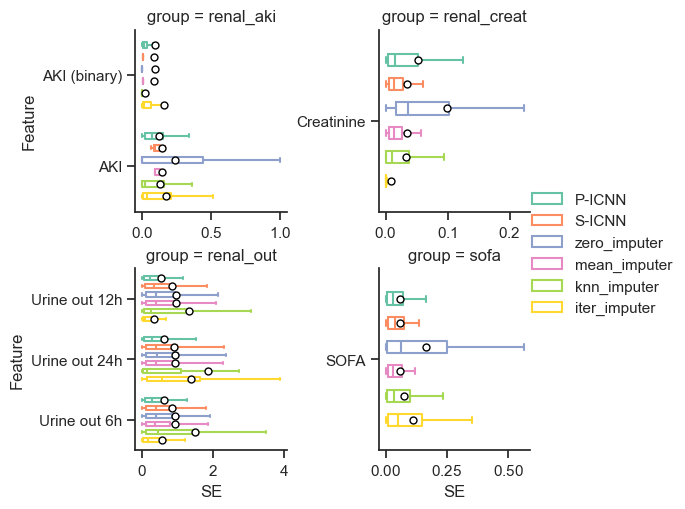

In [75]:
# enzymes (except Amylase, Bilirubin indirect, CK-CPK)
# renal_creat
# renal_aki
# renal_out
# sofa

X_test_se_df_selection = final_models_X_test_se[final_models_X_test_se.group.isin(['renal_out', 'renal_creat', 'renal_aki', 'sofa'])]

grid = sns.FacetGrid(data=X_test_se_df_selection, col="group", sharex=False, sharey=False, col_wrap=2,  )

grid.map_dataframe(sns.boxplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
                   showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'5'},
                    # line_kws=dict(linewidth=1.5, color="#cde"),
                    showfliers=False,
                    fill=False,
                     gap=0.5)

# grid.map_dataframe(sns.boxenplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
#                     # line_kws=dict(linewidth=1.5, color="#cde"),
#                     showfliers=False,
#                     fill=False,
#                      gap=0.5)

grid.add_legend()
grid.figure.set_size_inches(fig_width_in * 1.2, fig_height_in * 3)
grid.savefig(f"{RESULTS_DIR}/X_test_se_df_selection.pdf")

In [76]:
all_models_features_stats_df

,$R^2$,MSE,Feature,Imputer,"$r(SE, \hat{\sigma}^2)$","$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin
0,-18.791556,0.338596,blood_chemistry.albumin,ICNN_LN,-0.095714,"$r \in [-0.1, 0.1]$",$R^2 < -9$
1,-0.633369,0.032923,blood_chemistry.aniongap,ICNN_LN,0.151935,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
2,-0.511465,0.020465,blood_chemistry.bicarbonate,ICNN_LN,0.113759,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
3,-0.219971,0.051564,blood_chemistry.bun,ICNN_LN,0.058487,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$"
4,-2.204620,0.012969,blood_chemistry.calcium,ICNN_LN,0.103926,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$"
...,...,...,...,...,...,...,...
95,0.452593,0.007647,vital.sbp,iter_imputer,NaN,NA,$R^2 > 0.25$
96,0.820376,0.002518,vital.sbp_ni,iter_imputer,NaN,NA,$R^2 > 0.25$
97,-0.972564,0.001281,vital.spo2,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"
98,-0.918125,0.000421,vital.temperature,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"


In [77]:
final_models_stats_df.columns

Index(['Imputer', 'MSE', '$R^2$', 'MICRO-AVG($R^2$)', 'MACRO-AVG($R^2$)*',
       '$r_\text{Pearson}(SE, \hat{\sigma}^2)$',
       '$r_\text{Spearman}(SE, \hat{\sigma}^2)$',
       '$r_\text{Spearman}(R^2, \text{abundance})$'],
      dtype='object')

In [82]:
final_models_stats_df

,Imputer,MSE,$R^2$,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*,"$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(R^2, \text{abundance})$"
0,P-ICNN,0.081217,0.328510,0.190792,-8.052747,0.027086,0.196668,0.253702
0,S-ICNN,0.094326,0.220125,0.060177,-0.046894,NaN,NaN,-0.135166
0,zero_imputer,0.188635,-0.559605,-0.879470,-4.101035,NaN,NaN,-0.420739
0,mean_imputer,0.100373,0.170128,-0.000074,-0.000799,NaN,NaN,0.413396
0,knn_imputer,0.142751,-0.180250,-0.422312,0.143208,NaN,NaN,-0.142324
0,iter_imputer,0.086248,0.286912,0.140662,-0.229407,NaN,NaN,0.077502


In [84]:
table0 = final_models_stats_df.drop(axis=1, labels=[r'MACRO-AVG($R^2$)*', r'$R^2$', r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$',
       r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$']) .set_index('Imputer').transpose()
table0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table0.columns))
table0.columns = list(map(lambda c: c.replace("_", "\\_"), table0.columns))
table0.columns.name = 'Imputer'
table0 = table0.sort_values('MSE', axis=1, ascending=False)
table0

Imputer,\texttt{zero\_imputer},\texttt{knn\_imputer},\texttt{mean\_imputer},\texttt{S-ICNN},\texttt{iter\_imputer},\texttt{P-ICNN}
MSE,0.188635,0.142751,0.100373,0.094326,0.086248,0.081217
MICRO-AVG($R^2$),-0.879470,-0.422312,-0.000074,0.060177,0.140662,0.190792
"$r_\text{Spearman}(R^2, \text{abundance})$",-0.420739,-0.142324,0.413396,-0.135166,0.077502,0.253702


In [86]:
table0_stl = (table0.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'MICRO-AVG($R^2$)'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.12, high=0.28,  vmin=0.09, vmax=0.19, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table0_stl

Imputer,\texttt{zero\_imputer},\texttt{knn\_imputer},\texttt{mean\_imputer},\texttt{S-ICNN},\texttt{iter\_imputer},\texttt{P-ICNN}
MSE,0.189,0.143,0.100,0.094,0.086,0.081
MICRO-AVG($R^2$),-0.879,-0.422,-0.000,0.060,0.141,0.191
"$r_\text{Spearman}(R^2, \text{abundance})$",-0.421,-0.142,0.413,-0.135,0.078,0.254


In [88]:
table0_str = (table0_stl.to_latex(caption=r"First row: \gls*{mse} loss across all features on the test split. "
                                  r"Second row: micro average of $R^2$ across features (higher is better) ." 
                                  r"Third row: correlation between the predictive performance (via $R^2$) and presence percentage.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table0_str)

\begin{table}
\centering
\caption{First row: \gls*{mse} loss across all features on the test split. Second row: micro average of $R^2$ across features (higher is better) .Third row: correlation between the predictive performance (via $R^2$) and presence percentage.}
\begin{tabular}{lrrrrrr}
\hline
Imputer & \texttt{zero\_imputer} & \texttt{knn\_imputer} & \texttt{mean\_imputer} & \texttt{S-ICNN} & \texttt{iter\_imputer} & \texttt{P-ICNN} \\
\hline
MSE & {\cellcolor[HTML]{F57245}} \color[HTML]{F1F1F1} 0.189 & {\cellcolor[HTML]{F1F9AC}} \color[HTML]{000000} 0.143 & {\cellcolor[HTML]{45AD5B}} \color[HTML]{F1F1F1} 0.100 & {\cellcolor[HTML]{249D53}} \color[HTML]{F1F1F1} 0.094 & {\cellcolor[HTML]{0F8446}} \color[HTML]{F1F1F1} 0.086 & {\cellcolor[HTML]{05713C}} \color[HTML]{F1F1F1} 0.081 \\
MICRO-AVG($R^2$) & -0.879 & -0.422 & -0.000 & 0.060 & 0.141 & 0.191 \\
$r_\text{Spearman}(R^2, \text{abundance})$ & -0.421 & -0.142 & 0.413 & -0.135 & 0.078 & 0.254 \\
\hline
\end{tabular}
\end{table}



In [57]:
prob_corr_df = all_models_stats_df.loc[all_models_stats_df.Imputer.isin(['ICNN_LN', 'ICNN_NLN', 'ICNN_NKL', 'ICNN_KL']), ['Imputer', r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$', r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$']]

In [58]:
table1_stl = (prob_corr_df.style.format(precision=3).hide())
table1_str = table1_stl.to_latex(caption=r"Correlation between predicted Gaussian variance $\sigma^2$ by \texttt{ICNN\_LN} and the prediction \gls*{se}.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
print(table1_str)

\begin{table}
\centering
\caption{Correlation between predicted Gaussian variance $\sigma^2$ by \texttt{ICNN\_LN} and the prediction \gls*{se}.}
\begin{tabular}{lrr}
\toprule
Imputer & $r_\text{Pearson}(SE, \hat{\sigma}^2)$ & $r_\text{Spearman}(SE, \hat{\sigma}^2)$ \\
\midrule
ICNN_LN & 0.486 & 0.529 \\
ICNN_NLN & 0.359 & 0.523 \\
ICNN_KL & 0.012 & 0.182 \\
ICNN_NKL & 0.027 & 0.197 \\
\bottomrule
\end{tabular}
\end{table}



In [59]:
prob_models_features_stats_df = all_models_features_stats_df[all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$'].notnull()]
prob_models_features_stats_df = prob_models_features_stats_df[prob_models_features_stats_df.Feature.isin(vars_n300)]
r_bins = prob_models_features_stats_df.groupby(['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin'])['Feature'].count().reset_index()
r_bins.columns = ['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin', 'Count']
r_bins = r_bins.pivot_table(index="Imputer", values='Count', columns=r'$r(SE, \hat{\sigma}^2)$ bin')

# r_bins = r_bins[r_classes]
r_bins


"$r(SE, \hat{\sigma}^2)$ bin",$r > 0.3$,"$r \in [-0.1, 0.1]$","$r \in [0.1, 0.3]$",$r \leq -0.1$
Imputer,,,,
ICNN_KL,1.0,51.0,19.0,2.0
ICNN_LN,4.0,43.0,25.0,1.0
ICNN_NKL,1.0,57.0,15.0,NaN
ICNN_NLN,3.0,53.0,17.0,NaN


In [94]:
final_models_features_stats_df


,$R^2$,MSE,Feature,Imputer,"$r(SE, \hat{\sigma}^2)$","$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin
0,-1.916952,0.049904,blood_chemistry.albumin,P-ICNN,0.117000,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$"
1,-0.676229,0.033787,blood_chemistry.aniongap,P-ICNN,0.109406,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
2,-0.880132,0.025457,blood_chemistry.bicarbonate,P-ICNN,0.065658,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$"
3,-0.216735,0.051427,blood_chemistry.bun,P-ICNN,-0.001759,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$"
4,-4.032030,0.020365,blood_chemistry.calcium,P-ICNN,0.100367,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$"
...,...,...,...,...,...,...,...
95,0.452593,0.007647,vital.sbp,iter_imputer,NaN,NA,$R^2 > 0.25$
96,0.820376,0.002518,vital.sbp_ni,iter_imputer,NaN,NA,$R^2 > 0.25$
97,-0.972564,0.001281,vital.spo2,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"
98,-0.918125,0.000421,vital.temperature,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"


In [97]:
final_models_filtered_features_stats_df = final_models_features_stats_df[final_models_features_stats_df.Feature.isin(vars_n300)]
R_bins = final_models_filtered_features_stats_df.groupby(['Imputer', r'$R^2$ bin'])['Feature'].count().reset_index()
R_bins.columns = ['Imputer', r'$R^2$ bin', 'Count']
R_bins = R_bins.pivot_table(index="Imputer", values='Count', columns=r'$R^2$ bin')

R_bins = R_bins[R_classes]
R_bins

$R^2$ bin,$R^2 > 0.25$,"$R^2 \in (0.1, 0.25]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$",$R^2 < -9$
Imputer,,,,,,
P-ICNN,3.0,2.0,4.0,35.0,23.0,6.0
S-ICNN,NaN,1.0,70.0,1.0,1.0,NaN
iter_imputer,27.0,1.0,2.0,36.0,7.0,NaN
knn_imputer,29.0,8.0,9.0,27.0,NaN,NaN
mean_imputer,NaN,NaN,73.0,NaN,NaN,NaN
zero_imputer,NaN,NaN,5.0,15.0,51.0,2.0


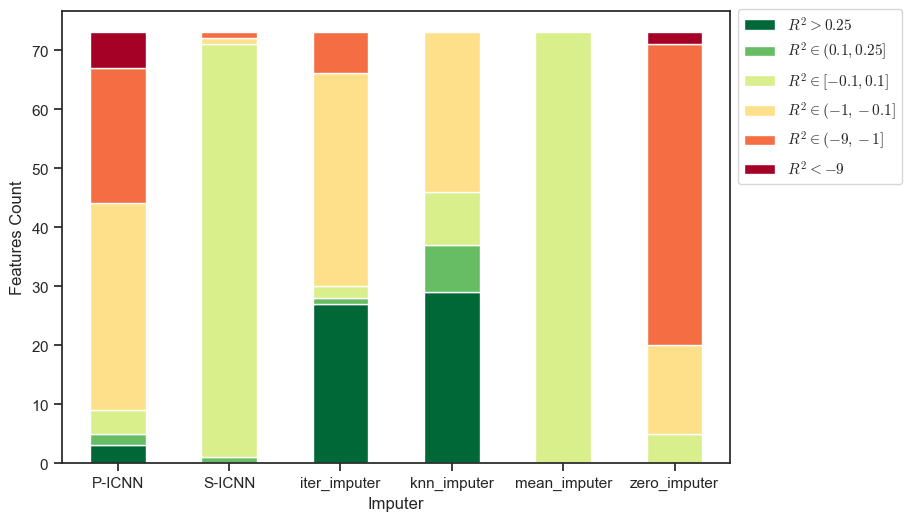

In [99]:
ax = R_bins.iloc[:6, :].plot(y=R_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 1.5, fig_height_in * 3)
ax.get_figure().savefig(f"{RESULTS_DIR}/R2_bins.pdf")

In [63]:
icnn_ = all_models_filtered_features_stats_df[all_models_filtered_features_stats_df.Imputer.str.startswith('ICNN')]
icnn_[icnn_[r'$R^2$'] < -10].groupby('Imputer')['Feature'].count()

Imputer
ICNN_KL     7
ICNN_LN     8
ICNN_MSE    1
ICNN_NKL    6
ICNN_NLN    2
Name: Feature, dtype: int64

In [116]:
def comp_icnn_iter(x):
    picnn_r2 =  x[x['Imputer'] == 'P-ICNN'][r'$R^2$']
    iter_r2 =  x[x['Imputer'] == 'iter_imputer'][r'$R^2$']
    return  (picnn_r2 < iter_r2).iloc[0]



lessthan = final_models_filtered_features_stats_df.groupby('Feature').apply(comp_icnn_iter)

In [126]:
lessthan.to_numpy()[:-1]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0], dtype=object)

In [128]:
lessthan_p = lessthan.index.map(p_abundance)
lessthan_p.to_numpy().dtype

dtype('float64')

In [132]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(lessthan.to_numpy()[:-1].astype(int), 
                                         -lessthan_p.to_numpy()[:-1])
metrics.auc(fpr, tpr)

0.6701149425287356

In [113]:
final_models_filtered_features_stats_df

,$R^2$,MSE,Feature,Imputer,"$r(SE, \hat{\sigma}^2)$","$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin
0,-1.916952,0.049904,blood_chemistry.albumin,P-ICNN,0.117000,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$"
1,-0.676229,0.033787,blood_chemistry.aniongap,P-ICNN,0.109406,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
2,-0.880132,0.025457,blood_chemistry.bicarbonate,P-ICNN,0.065658,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$"
3,-0.216735,0.051427,blood_chemistry.bun,P-ICNN,-0.001759,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$"
4,-4.032030,0.020365,blood_chemistry.calcium,P-ICNN,0.100367,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$"
...,...,...,...,...,...,...,...
95,0.452593,0.007647,vital.sbp,iter_imputer,NaN,NA,$R^2 > 0.25$
96,0.820376,0.002518,vital.sbp_ni,iter_imputer,NaN,NA,$R^2 > 0.25$
97,-0.972564,0.001281,vital.spo2,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"
98,-0.918125,0.000421,vital.temperature,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"


In [ ]:
picnn_less_iter = pd.DataFrame({'picnn_less_iter': },
                                index=

In [109]:
 final_models_filtered_features_stats_df.groupby('Feature').

AttributeError: 'DataFrameGroupBy' object has no attribute 'index'